## Question 3: Metallicity

**Summary:** *The radial metallicity relation is a function that describes the change of metallicity - here the gas phase metallicity A(O) = log10(NO/NH) + 12 - along the galactocentric cylindrical radius RGal.. Understanding the radial metallicity gradient in galaxies provides critical insights into their formation and evolutionary processes, such as inside-out formation, gas accretion, outflows, and radial migration. A lot of work has been done through observational studies (e.g. Ho et al., 2017, ApJ, 846, 39) and a few simulations (e.g. Grand et al., 2016, MNRAS, 460, 94), but more works needs to be done to understand the radial metallicity gradient! Your colleague has just finished an exciting cosmological simulation that traces the gas phase metallicity for a Milky Way analogue, that is, a spiral galaxy. They have limited the simulation data to the positions (x, y, z) of the innermost gas particles (RGal. < 25 kpc) and their gas phase metallicity A(O) and uploaded them as a FITS file for you here: https://github.com/svenbuder/astr4004_2025_week8/blob/main/data/nihao_uhd_simulation_g8.26e11_xyz_positions_and_oxygen_ao.fits*

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import fits
from matplotlib.colors import LogNorm
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from scipy.stats import binned_statistic_2d
from matplotlib import rcParams

In [72]:
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:
# Import fits data
hdul = fits.open('../data/nihao_uhd_simulation_g8.26e11_xyz_positions_and_oxygen_ao.fits')
data = hdul[1].data
header = hdul[1].header
print(hdul.info())
hdul.close()

metal_pd = Table(data)
metal_pd = metal_pd.to_pandas()

display(metal_pd.head())

Filename: ../data/nihao_uhd_simulation_g8.26e11_xyz_positions_and_oxygen_ao.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   (678,)   uint8   
  1  /Users/buder/Simulations/preparing_NIHAO/NIHAO_prepared/NIHAO_g8.26e    1 BinTableHDU     21   511520R x 4C   ['E', 'E', 'E', 'D']   
None


,x,y,z,A_O
0,10.020546,-15.421509,-3.241711,8.428943
1,-13.487837,5.663507,-0.802306,8.671107
2,6.642289,-0.138942,-0.585961,8.891596
3,0.203939,4.112373,-0.147622,8.977195
4,-20.824045,6.971037,-1.758061,8.326950


In [48]:
# Create the cylindrical radius
metal_pd['radius'] = np.sqrt(metal_pd['x']**2 + metal_pd['y']**2)# + metal_pd['z']**2) # Do we need to have the z here as well?

/var/folders/p7/q8wsc25n16d1867zxd46f3b80000gn/T/ipykernel_39000/3389547785.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()
/var/folders/p7/q8wsc25n16d1867zxd46f3b80000gn/T/ipykernel_39000/3389547785.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_fit = model.params[0] + model.params[1] * x_array_smooth
/var/folders/p7/q8wsc25n16d1867zxd46f3b80000gn/T/ipykernel_39000/3389547785.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax1.plot(x_array_smooth, y_fit, color='

<Figure size 640x480 with 0 Axes>

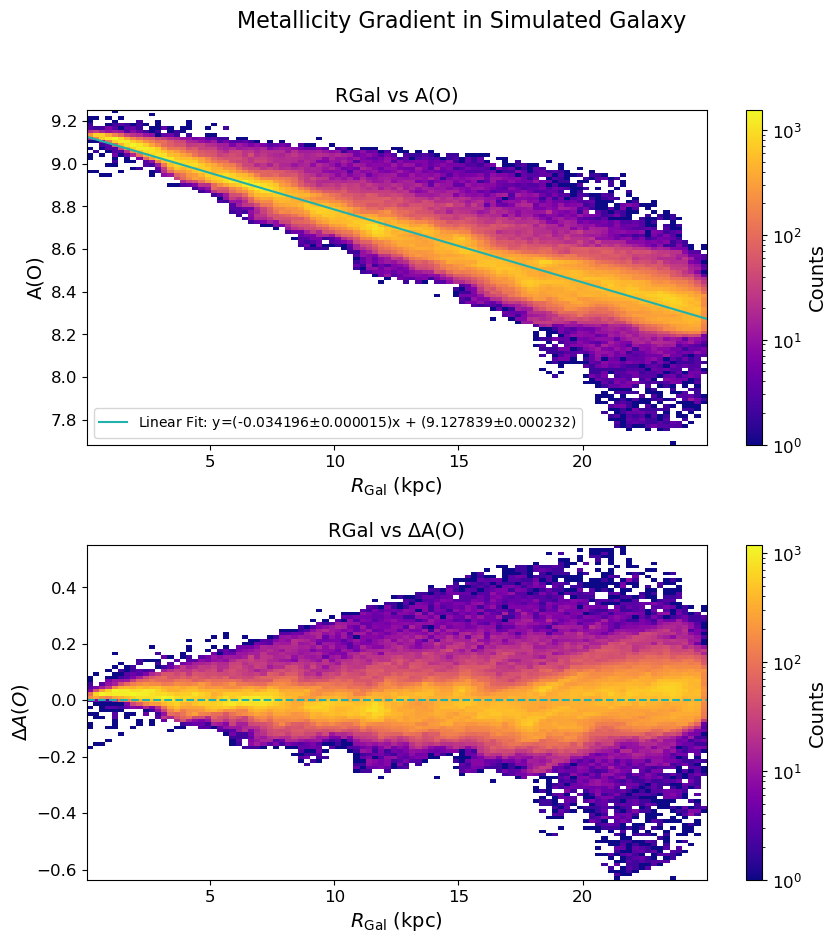

In [103]:
"""Plot a 2-panel figure:
– (a) Logarithmic density plot of RGal. vs. A(O), with a linear fit and legend.
– (b) Residuals of the fit, RGal. vs. ΔA(O)."""

def lin_fit_sm(x, y):
    mask = ~np.isnan(x) & ~np.isnan(y)
    x_fit = x[mask]
    y_fit = y[mask]

    # Add intercept
    x_with_intercept = sm.add_constant(x_fit)
    model = sm.OLS(y_fit, x_with_intercept).fit()
    return model

plt.clf()
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
fig.subplots_adjust(hspace=0.3)
fig.suptitle('Metallicity Gradient in Simulated Galaxy', fontsize=16)

# Logarithmic density plot
h1 = ax1.hist2d(metal_pd['radius'],metal_pd['A_O'],bins = 100,norm = LogNorm(), cmap='plasma')
cbar = plt.colorbar(h1[-1], ax=ax1, label = 'Counts')
ax1.set_xlabel(r'$R_\text{Gal}$ (kpc)')
ax1.set_ylabel('A(O)')
ax1.legend()
ax1.set_title('RGal vs A(O)', fontsize=14)
# Linear fit weighted evenly
model = lin_fit_sm(metal_pd['radius'], metal_pd['A_O'])
x_array_smooth = np.linspace(metal_pd['radius'].min(), metal_pd['radius'].max(), 200)
y_fit = model.params[0] + model.params[1] * x_array_smooth
ax1.plot(x_array_smooth, y_fit, color='lightseagreen', label=fr'Linear Fit: y=({model.params[1]:.6f}$\pm${model.bse[1]:.6f})x + ({model.params[0]:.6f}$\pm${model.bse[0]:.6f})')
ax1.legend(loc='lower left')

# Residuals of the fit
residuals = metal_pd['A_O'] - (model.params[0] + model.params[1] * metal_pd['radius'])
h2 = ax2.hist2d(metal_pd['radius'], residuals, bins=100, norm=LogNorm(), cmap='plasma')
cbar = plt.colorbar(h2[-1], ax=ax2, label='Counts')
ax2.axhline(0, color='lightseagreen', linestyle='--')
ax2.set_xlabel(r'$R_\text{Gal}$ (kpc)', fontsize=14)
ax2.set_ylabel(r'$\Delta A(O)$', fontsize=14)
ax2.set_title('RGal vs ΔA(O)', fontsize=14)
plt.savefig('../figures/ao_vs_Rgal.png', dpi = 200)
plt.show()

In the above plot, we report our fit to 6 decimal places as this matches the precision provided in the simulation data. We do not provide our fit with any hyperparameters. To discuss the goodness of fit, we can use the OLS model summary, which provides us with a number of useful statistical tests.

In [95]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    A_O   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                 5.337e+06
Date:                Tue, 07 Oct 2025   Prob (F-statistic):               0.00
Time:                        17:46:03   Log-Likelihood:             6.1547e+05
No. Observations:              511520   AIC:                        -1.231e+06
Df Residuals:                  511518   BIC:                        -1.231e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.1278      0.000   3.93e+04      0.000       9.127       9.128
radius        -0.0342   1.48e-05  -2310.203      0.000      -0.034      -0.034
==============================================================================
Omnibus:                    66623.269   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           564064.307
Skew:                           0.349   Prob(JB):                         0.00
Kurtosis:                       8.097   Cond. No.                         36.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [96]:
# Add RMS calculation
rmse = np.sqrt(mean_squared_error(metal_pd['A_O'], model.params[0] + model.params[1] * metal_pd['radius']))
print(f'Root Mean Square Error (RMSE): {rmse:.3f}')
print(f'Max residual: {np.max(np.abs(residuals)):.3f}')
print(f'Mean residual: {np.mean(residuals):.6f}')

Root Mean Square Error (RMSE): 0.073
Max residual: 0.636
Mean residual: 0.000000


/var/folders/p7/q8wsc25n16d1867zxd46f3b80000gn/T/ipykernel_39000/1824185304.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse = np.sqrt(mean_squared_error(metal_pd['A_O'], model.params[0] + model.params[1] * metal_pd['radius']))


As we can see, this is a good fit globally. The high $R^2$ of 0.913 value suggests strong negative correlation in the data, and tells us that only a ~8.7% of the variance the data cannot be explained by this model. The F-statistic shows that the ratio of explained variance to unexplained variance is very high, on the order of $10^6$. This is corroborated by the low RMS. However, we can see from our residual plot that certain radii do not match the model as well. Regions with large positive residuals show where the gas is locally more metal-rich than the model, and large negative residuals are contrastingly metal-poor. The variance of the residuals increase with radius, resulting in much larger diagreements with the model. We can visualise the trend of residuals as a function of R by plotting the mean residual in each R bin.

<Figure size 640x480 with 0 Axes>

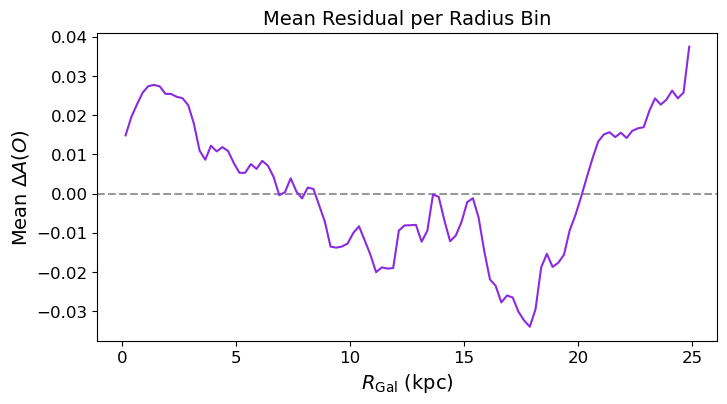

In [ ]:
n_bins = 100
radius_bins = np.linspace(metal_pd['radius'].min(), metal_pd['radius'].max(), n_bins + 1)
bin_indices = np.digitize(metal_pd['radius'], radius_bins) - 1

mean_residuals = [residuals[bin_indices == i].mean() for i in range(n_bins)]
bin_centers = 0.5 * (radius_bins[:-1] + radius_bins[1:])

plt.clf()
plt.figure(figsize=(8, 4))
plt.axhline(0, linestyle='--', color='k', alpha=0.4)
plt.plot(bin_centers, mean_residuals, color='blueviolet')
plt.xlabel(r'$R_\text{Gal}$ (kpc)', fontsize=14)
plt.ylabel(r'Mean $\Delta A(O)$', fontsize=14)
plt.title('Mean Residual per Radius Bin', fontsize=14)
plt.show()

This suggests that the model is fit poorest at the centre and edge of the galaxy, and demonstrates negative peaks around 11 and 18 kpc. The largest residuals are at large radii, where the model seemingly underpredicts the "true" metallicity by an average of 0.04 dex.

/var/folders/p7/q8wsc25n16d1867zxd46f3b80000gn/T/ipykernel_39000/4033694571.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  a_o_fit = model.params[0] + model.params[1] * metal_pd['radius']


<Figure size 640x480 with 0 Axes>

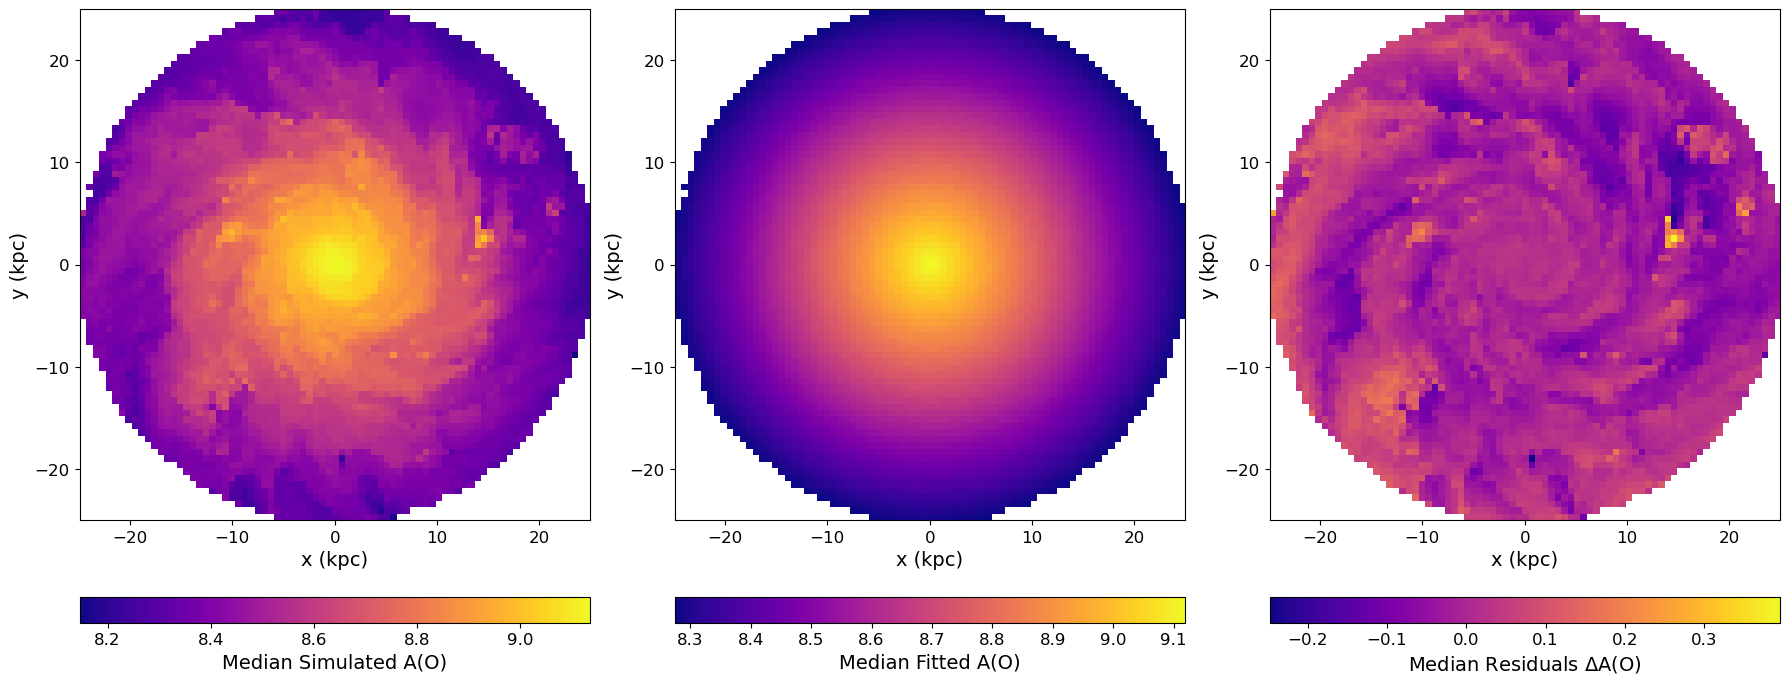

In [101]:
"""Plot a 3-panel figure for the x vs. y plane using the same bins and sensible colormaps:
– (a) 2D-histogram of the median simulated A(O).
– (b) 2D-histogram of the median fitted A(O)
– (c) 2D-histogram of the median residuals ΔA(O)."""

n_bins = 79
a_o_fit = model.params[0] + model.params[1] * metal_pd['radius']
residuals = metal_pd['A_O'] - a_o_fit


# Median simulated A(O)
median_a_o, x_edge, y_edge, _ = binned_statistic_2d(metal_pd['x'], metal_pd['y'], metal_pd['A_O'], statistic='median', bins=n_bins)

# Median fitted A(O)
median_a_o_fit, _, _, _ = binned_statistic_2d(metal_pd['x'], metal_pd['y'], a_o_fit, statistic='median', bins=n_bins)

# Median residuals ΔA(O)
median_residuals, _, _, _ = binned_statistic_2d(metal_pd['x'], metal_pd['y'], residuals, statistic='median', bins=n_bins)


plt.clf()
fig, axes = plt.subplots(1, 3, figsize=(18, 8))
im0 = axes[0].imshow(median_a_o.T, aspect='equal', cmap='plasma', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]])
fig.colorbar(im0, ax=axes[0], location='bottom', pad=0.1, label='Median Simulated A(O)')
im1 = axes[1].imshow(median_a_o_fit.T, aspect='equal', cmap='plasma', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]])
fig.colorbar(im1, ax=axes[1], location='bottom', pad=0.1, label='Median Fitted A(O)')
im2 = axes[2].imshow(median_residuals.T, aspect='equal', cmap='plasma', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]])
fig.colorbar(im2, ax=axes[2], location='bottom', pad=0.1, label=r'Median Residuals $\Delta$A(O)')
for ax in axes:
    ax.set_xlabel('x (kpc)', fontsize=14)
    ax.set_ylabel('y (kpc)', fontsize=14)
plt.tight_layout()
plt.savefig('../figures/ao_xy_plane.png', dpi=200)
plt.show()

We choose to use 79 bins along each axis, as this is the largest number of bins without any NaN (x,y) positions. Ordinarily, you would want to balance the number of bins with the data resolution. Reducing the number of bins would smooth over detailed features and could supress important signals such as local variation, or statistical noise. Increasing the number of bins would reduce the signal-to-noise, and a combination of empty bins and low signal can also hide key features such as gradients. Our binning provides us with enough signal per bin to reliably estimate the medians and structures such as the spiral arms.

Looking more closely at the residuals, we can clearly see a correlation between the variance and the structure of the spiral arms. We see a trend of positive residuals in the spiral arms, and negative residuals in the space between them with clear separation. This is in agreement with the understanding that star formation occurs in these overdensities, resulting in the enrichment of these dusty lanes from feedback from the stellar lifecycle. Oxygen is a key product of stellar nucleosynthesis and is typically fed back into the ISM in massive supernova. We see a strong feature in both the simulation and residual at an (x,y) position around x=15, y=2 - this high local metallicity could be explained by a feedback event such as a supernova enriching the local material, either from an isolated instance or in a starburst. Based on the x,y residual plot, it seems like the apparent high variance at large radii is due to the simulation boundary aligning with multiple of the spiral arms, and is not a genuine trend with R in this simulation.